In [393]:
import numpy as np

from diffractio import degrees, mm, nm, um
from diffractio import np, plt, sp
from diffractio.scalar_sources_XY import Scalar_source_XY

from skimage.measure import block_reduce#to perform mean pooling
from scipy import ndimage
from skimage.transform import resize

import datetime
from tqdm import tqdm


def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

from PIL import Image
from pathlib import Path

import os
os.getcwd()

'/Users/rui/My Drive (alhavaite.rui@gmail.com)/Course on AI and ML/Jupyter notebooks/Capstone competition/final_submission'

## Generate Hermite Gaussian modes with arbitrary operations for dataset augmentation

Implementation of laguerre gaussian beams following module difractio:

https://diffractio.readthedocs.io/en/latest/source/tutorial/scalar_XY/sources_xy.html

In [416]:
def generate_arb_mode(size = (32, 32)):

    N = int(np.random.choice([0, 1, 2]))
    M = int(np.random.choice([0, 1, 2]))
    
    x0 = np.linspace(-1 * mm, 1 * mm, 512)
    y0 = np.linspace(-1 * mm, 1 * mm, 512)
    wavelength = 0.6238 * um

    u = Scalar_source_XY(x=x0, y=y0, wavelength=wavelength)

    u.hermite_gauss_beam(A=1,
                         r0=(0, 0), #position of waist in um
                         w0=[0.2 * mm, 0.2 * mm],
                         z0=(0, 0 * mm),
                         z=0,
                         n=N,
                         m=M)


    #Normalise intensity
    intensity = np.abs(u.u)**2
    intensity = intensity / np.max(intensity) #normalise

    #rotate and crop
    rot_angle = np.random.uniform(low=-10., high=10.) #rotate
    intensity = ndimage.rotate(intensity, rot_angle, reshape=False)
    crop_x, crop_y = int(len(x0)*0.9), int(len(x0)*0.9) #crop
    intensity = crop_center(intensity, cropx = crop_x, cropy= crop_y)
    
    #Shift image
    non = lambda s: s if s<0 else None
    mom = lambda s: max(0,s)
    ox = int(np.random.uniform(low = -0.35, high = 0.35) * len(x0))
    oy = int(np.random.uniform(low = -0.35, high = 0.35) * len(y0))
    
    shift_intensity = np.zeros_like(intensity)
    shift_intensity[mom(oy):non(oy), mom(ox):non(ox)] = intensity[mom(-oy):non(-oy), mom(-ox):non(-ox)]
    intensity = shift_intensity
    
    #Add noise
    intensity = intensity\
                +np.random.normal(loc = 0, scale = 0.2, size = (intensity.shape))

    #Resize to (m x n pixels)
    intensity = resize(intensity, size) #resize
    
    mode_info = [M, N]
    
    return intensity, mode_info


## Generate arbitrary modes and save as .tif image (8 bit grayscale)

### Generate train set (32x32 pixels)

In [419]:
for idx in tqdm(range(10**4)): #generated 10**4 for the train set and 10**3 for the test set
#for idx in tqdm(range(1)):
    #Generate image
    i, mode_info = generate_arb_mode(size = (32, 32))
    i = (((i - i.min()) / (i.max() - i.min())) * 255.9).astype(np.uint8) #to save like a 8bit gray scale image

    #Save image
    im = Image.fromarray(i)
    
    now = datetime.datetime.now()
    timestamp = str(now.strftime("%Y%m%d_%H%M%S"))
    label = f"{timestamp} M={mode_info[0]:.0f} N={mode_info[1]:.0f} i={idx}"
    img_path = "/data_images/"+label+".tif"
    img_path = Path(os.getcwd())/"data_images/32by32/train"
    #img_path = Path(os.getcwd())/"data_images/16by16/test/"
    im.save(str(img_path/label)+".tif")

    #Load image - for debugging
    #reloaded = np.array(Image.open(label+'.tif')) #used tif, because it as no compression;


100%|█████████████████████████████████████| 10000/10000 [10:22<00:00, 16.06it/s]


### Generate test set (32x32 pixels)

In [420]:
for idx in tqdm(range(10**3)): #generated 10**4 for the train set and 10**3 for the test set
    #Generate image
    i, mode_info = generate_arb_mode(size = (32, 32))
    i = (((i - i.min()) / (i.max() - i.min())) * 255.9).astype(np.uint8) #to save like a 8bit gray scale image

    #Save image
    im = Image.fromarray(i)
    
    now = datetime.datetime.now()
    timestamp = str(now.strftime("%Y%m%d_%H%M%S"))
    label = f"{timestamp} M={mode_info[0]:.0f} N={mode_info[1]:.0f} i={idx}"
    img_path = "/data_images/"+label+".tif"
    #img_path = Path(os.getcwd())/"data_images/16by16/train"
    img_path = Path(os.getcwd())/"data_images/32by32/test/"
    im.save(str(img_path/label)+".tif")

    #Load image - for debugging
    #reloaded = np.array(Image.open(label+'.tif')) #used tif, because it as no compression;


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.21it/s]


## Visualise modes 

Text(0.5, 1.0, 'mode = [1, 1]')

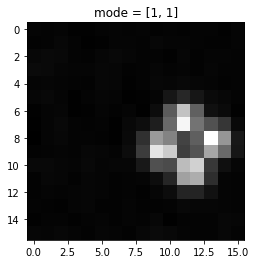

In [413]:
i, mode_info = generate_arb_mode(size = (16, 16))
i = (((i - i.min()) / (i.max() - i.min())) * 255.9).astype(np.uint8) #to save like a 8bit gray scale image
plt.imshow(i, cmap = "gray")
plt.title(f"mode = {mode_info}")